# Study of time step depedency, for the cell fate model

In [1]:
# Set up working environment
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import pandas as pd
import numpy as np
import os

import maboss
import subprocess

# Set seaborn style and create color maps: white-black scale and blue-light-red for ratios
sns.set_style("white")
colormap_scale = sns.light_palette("black", as_cmap=True)
colormap_ratios = sns.diverging_palette(240, 0, center='light', as_cmap=True)

# Shortcut to save figures with a common pattern and format
def save_figure(figure, title):
    figure.savefig("figure_%s.pdf" % title, bbox_inches="tight")

# Simulation of the wild type model with TNF active

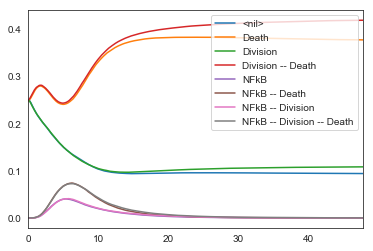

In [2]:
# Set up the example files
bnd_file ="CellFateModel_uppmaboss.bnd"
cfg_WT = "CellFateModel_uppmaboss.cfg"
upp_file = "CellFateModel_uppmaboss.upp"
workdir  = "WT"

# Load the Wild-Type model
model_WT = maboss.load(bnd_file, cfg_WT)
model_48h = maboss.copy_and_update_parameters(model_WT, {'max_time':48})

# for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
#     model_48h.network[name].is_internal = True

model_48h.network.set_output(('Death','Division','NFkB'))
run_48h = model_48h.run()

run_48h.get_states_probtraj().plot()


According to the results of the WT simulation, consider Time Step <= 1, because the first local extremum is at time = 1

Step ratio: 1
Step ratio: 2
Step ratio: 3
Step ratio: 4


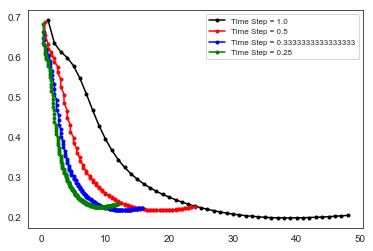

In [3]:
max_time = model_WT.param["max_time"]
time_tick = model_WT.param["time_tick"]

ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()
for ratio,color in ratios.items():
    print("Step ratio:", ratio)
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model = maboss.copy_and_update_parameters(model_WT, params)

    # Run UpPMaBoSS on the modified setup
    rwd = "%s_R%s" % (workdir, ratio)
    uppModel_step = maboss.UpdatePopulation(step_model, upp_file)
    
  
    uppModel_step.setStepNumber(48*ratio)
    
    run_step = uppModel_step.run(rwd)
    pop_ratios = run_step.get_population_ratios()
    pop_ratios = pop_ratios[1:]
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()

The asymptotic behavior of the cell population is robust, but the time to reach the asymptotic behavior varies. 

# Simulation of the wild type model with no TNF

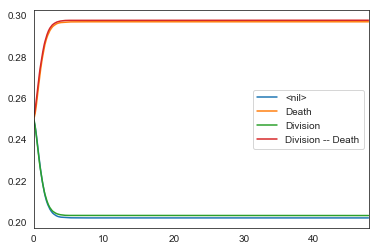

In [4]:
#Create a model for 48h with no TNF

model_48h_noTNF = maboss.copy_and_update_parameters(model_WT, {'max_time':48})
model_48h_noTNF.network.set_istate('TNF',[1,0])

for name in "mcIAP mXIAP mROS NonACD Apoptosis Survival TNF ATP FADD cIAP FASL TNFR DISC_TNF DISC_FAS RIP1 RIP1ub RIP1K IKK CASP8 BAX BCL2 ROS MPT MOMP SMAC Cyt_c XIAP apoptosome CASP3 cFLIP".split(' '):
    model_48h_noTNF.network[name].is_internal = True

model_48h_noTNF.network.set_output(('Death','Division','NFkB'))
run_48h_noTNF = model_48h_noTNF.run()

run_48h_noTNF.get_states_probtraj().plot()

The simulation shows that the asymptotic solution is reached very fast and the window of variation is very small (between 0.2 and 0.3). Note that NFkB is not shown because it is always at 0. Consider also Time Step <= 1.

Step ratio: 1
Step ratio: 2
Step ratio: 3
Step ratio: 4


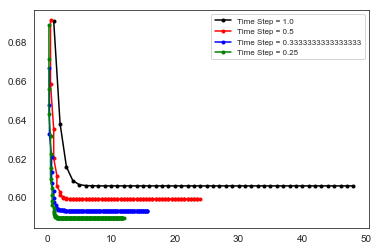

In [5]:
model_WT_noTNF = model_WT.copy()
model_WT_noTNF.network.set_istate('TNF',[1.0,0.0])
ratios = {1: "black", 2:"red", 3:"blue", 4:"green"}
fig, ax = plt.subplots()

upp_sims = []

for ratio,color in ratios.items():
    print("Step ratio:", ratio)
    # Update the max step and time tick based on the WT model
    params = {
        'max_time': "%g" % (max_time/ratio),
        "time_tick": "%g" % (time_tick/ratio)
    }
    step_model_noTNF = maboss.copy_and_update_parameters(model_WT_noTNF, params)

    
    # Run UpPMaBoSS on the modified setup
    rwd = "%s_noTNF_R%s" % (workdir, ratio)
    #uppModel_step_noTNF = maboss.UpdatePopulation(step_model_noTNF, step_upp_file)
    uppModel_step_noTNF = maboss.UpdatePopulation(step_model_noTNF, upp_file)
    uppModel_step_noTNF.setStepNumber(48*ratio)
    
    run_step_noTNF = uppModel_step_noTNF.run(rwd)
    upp_sims.append(run_step_noTNF)
    
    
    pop_ratios = run_step_noTNF.get_population_ratios()
    pop_ratios = pop_ratios[1:]

    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)


ax.legend(loc='upper right',prop={'size':8})
plt.show()


The different time step values show very little differences. 

A plot of the behavior between time = 0 and time = 10 is shown below.

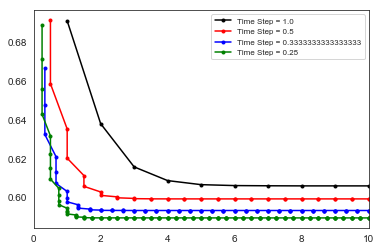

In [7]:
fig, ax = plt.subplots()
for i, (ratio,color) in enumerate(ratios.items()):
    pop_ratios = upp_sims[i].get_population_ratios()
    pop_ratios = pop_ratios[1:]
    
    time_steps = []
    pop_ratio_steps = []
    for step, pop_ratio in pop_ratios.items():
        time_steps.append(int(step)*max_time/ratio)
        pop_ratio_steps.append(float(pop_ratio))
    ax.plot(time_steps,pop_ratio_steps,'k.-',label='Time Step = '+str(1/ratio),c=color)
plt.xlim(0,10)
ax.legend(loc='upper right',prop={'size':8})
plt.show()
